In [58]:
try:       importlib.reload(Jupytils)
except:    import Jupytils
from Jupytils.Charts import *;
showTopbar("Markov Chain Asthma Prediction")
#Call delModules before reimporting to fresh imported classes
def delModules(mod):
    mods = []
    for c,md in enumerate(sys.modules): 
        if (md == mod or md.startswith(mod+".") ):
            #print("Delete: " , md)
            mods += [md]
    for m in sorted(mods):
        del sys.modules[m]

delModules("WeightedMarkov")
from WeightedMarkov.NaiveMarkov import *
from WeightedMarkov.WeightedHOMVMarkov import *


<IPython.core.display.Javascript object>

In [59]:
def categorize(df, colname="cat", newName=None, nq=10):
    zname = newName if newName is not None else colname+"_cat"
    if zname not in df.columns:
        df.insert(1, zname, 0)
    
    n = pd.qcut( df[colname], nq, labels=list(range(0,nq)) )
    n.loc[(n==0) | (n==1) | (n==2) ] = 0
    n.loc[(n==3) | (n==4) | (n==5) | (n==6) | (n==7)] = 1
    n.loc[(n==8) | (n==9) ] = 2

    df[zname] = n.values.astype(int);
    return df;

#categorize(df,'pef')

In [60]:
han1="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20patient_data_table";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
kimj="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kimj";
leeh="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20leeh";
sony="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20sony";
kuky="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kuky";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
patient="leeh2"
patient="hand2"
hand2="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20calculated_jlee%20WHERE%20pname=%27"+patient+"%27%20ORDER%20BY%20date,%20time"
fileName = hand2;

# => Load Data
proxies={'http':None, 'https':None}
#proxies = { "http": "http://proxy-lmi.global.lmco.com:80", "https": "http://proxy-lmi.global.lmco.com:80" }
df = LoadDataSet(fileName, checkForDateTime=False, proxies=proxies);

sdttm = df.date + " " + df.time 

if ('sdttm' not in df.columns):
    df.insert(0, 'sdttm', sdttm)
df.sdttm = pd.to_datetime(df.sdttm)
df.index=df.sdttm;

for i,u in enumerate(df.pef_zone.unique()):
    df.pef_zone[df.pef_zone == u]= i
df.pef_zone = df.pef_zone.astype(int)


## Lets run some regressions

In [61]:
def run_reg(X, y, reg, printDebug = False , scaler=None):
    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
    y_pred = y.copy()

    i = 0;
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        if (printDebug): print ("*",i, end ="");
        clf.fit(X_train,y_train)
        y_pred[test_index] = reg.predict(X_test)
        i = i +1;
    if (printDebug): print ("*", end="");
    
    if ( scaler ):
        y1 = scaler.inverse_transform(y)
        y2 = scaler.inverse_transform(y_pred)
    else:
        y1 = y;
        y2 = y_pred;
        
    m = mean_squared_error(y1, y2)
    r  = np.corrcoef(y, y_pred)[0,1]
    r2 = r2_score(y,y_pred)
    
    return y_pred, m, r, r2, clf


In [62]:
html = """<div class="container1">
    <div id="chart3" style="width: 100%;height: 350px;background: #eeeeee;">Div One</div> 
</div>
"""
display(HTML(html))

In [74]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcess
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from statsmodels.regression.quantile_regression import QuantReg
#import statsmodels.formula.api as smf
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

cols = []

for c in df.columns:
    if (c.lower().find('pef') >=0):
        pass; #print(c, end=' ' )
    else:
        cols.append(c)
t = df[cols].select_dtypes(include=[np.number])
t.columns

scaler = StandardScaler()
dp = prepareDF(t, True)
for c in dp.columns:
    dp[c] = scaler.fit_transform(dp[c])

y = scaler.fit_transform(df.pef)
X = dp.as_matrix().astype(np.float)
##---- Polynomial features
poly=2
p = PolynomialFeatures(poly)
o = p.fit_transform(X)
X = o

clf = KernelRidge(kernel='rbf', gamma=0.1, alpha=1)
clf = Ridge(alpha=50)
y_pred, m, r, r2, clf = run_reg(X, y, clf, printDebug = False , scaler=None)
#print(y, y_pred, m)
#plt.plot(y)
h=-150
cdf = pd.DataFrame({"y": y[:h], "y_pred": y_pred[:h]})
PlotHCts(cdf,  cdf.index, [0,1], div='chart3', ctype='line', title="Sample Chart for "+ patient );

df['y_pred'] = y_pred
print("MSE:", m, " r: ", r, " r2:", r2)


MSE: 0.947969267727  r:  0.381973762357  r2: 0.0520307322728


In [64]:
#==========> Categorize PEF VALUES
for c in 'pef precipitationpercent so2_sum co_sum o3_sum no2_sum pm10_sum y_pred'.split():
    categorize(df,c)
           
df.sort_values(by='sdttm', ascending=True, inplace=True)

df1= df['sdttm ampm pef_zone y_pred_cat pef_cat precipitationpercent_cat so2_sum_cat co_sum_cat o3_sum_cat no2_sum_cat pm10_sum_cat'.split()]

dfAM = df1[df1.ampm == 'am'].copy();
allDays = pd.date_range(dfAM.sdttm.min(), dfAM.sdttm.max(), freq='D')
#dfAM.index=dfAM.sdttm;
dfAM=dfAM.reindex(allDays, method='ffill') #fill_value=0) #'bfill')


dfPM = df1[df1.ampm == 'pm'].copy();
allDays = pd.date_range(dfPM.sdttm.min(), dfPM.sdttm.max(), freq='D')
#dfPM.index=dfPM.sdttm;
dfPM=dfPM.reindex(allDays, method='ffill') #fill_value=0) #'bfill')
displayDFs(dfAM);

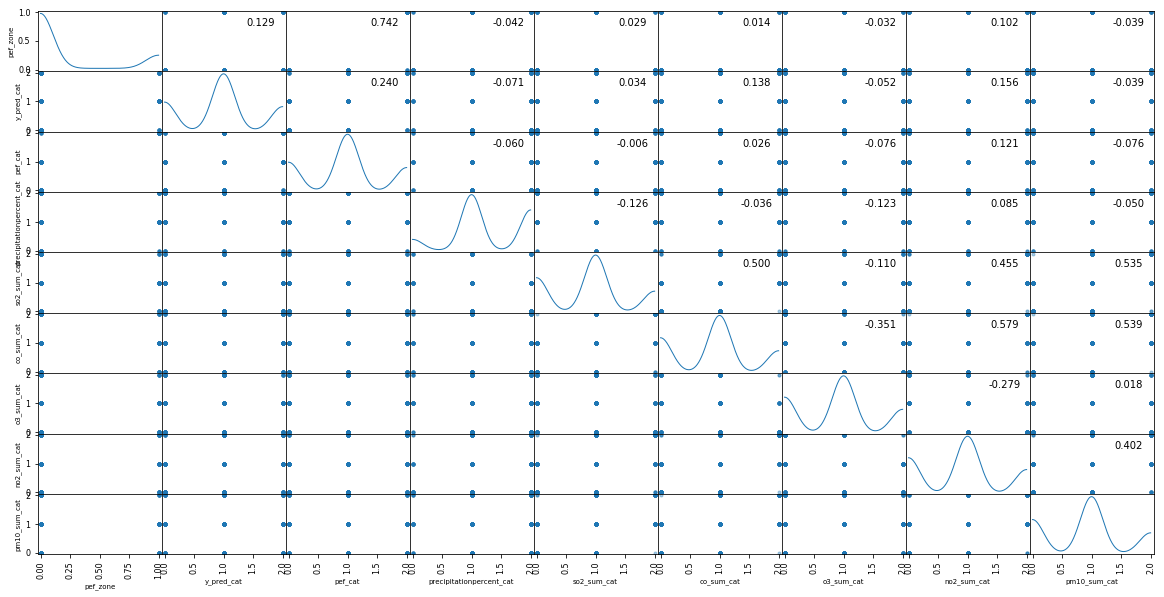

In [65]:
plotScatter = True
if (plotScatter):
    axes=scatter_matrix(dfAM, alpha=0.2, diagonal='kde', figsize=(20, 10)); # diagonal can be 'hist';
    corr = dfAM.corr().as_matrix()
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')


In [66]:
HIGHCHARTS_SCRIPTS = """
<script src="//code.highcharts.com/stock/highstock.js"></script>
<script src="//code.highcharts.com/highcharts-more.js"></script>
<script src="//code.highcharts.com/modules/exporting.js"></script>

<style>
.container1 {
    position: relative;
    width: 100%;
    background: white;
    overflow: hidden; /*To get your parent to respect the floated divs*/
}

.dash {
    position: relative;
    width: 50% !important; /*Because you only have 3 elements (100 divided by 3)*/
    height: 250px;
    float: left; /*To get them next to each other if all else fails*/
    background: #eeeeee;
    margins: 100px;
    padding: 10px;
    border: 1px solid gray;
}
</style>

<div class="container1">
    <div id="chart1" class="dash">Div One</div> 
    <div id="chart2" class="dash">Div Two</div>
</div>
"""


display(HTML(HIGHCHARTS_SCRIPTS))

In [67]:
ddf=dfAM;
PlotHCts(ddf,  ddf.index, 'pef_zone pef_cat precipitationpercent_cat so2_sum_cat co_sum_cat o3_sum_cat no2_sum_cat pm10_sum_cat'.split(' '), div='chart1', ctype='line', title="Sample Chart for "+ patient );
PlotHCts(ddf,  ddf.index, 'pef_zone pef_cat'.split(' '), div='chart2', ctype='line', title="Sample Chart for "+ patient );

## SCHAS PEF Predictions start here - Start with Naive Markov

We will use pefzone as we clasified and precipzone as aditional variable for higher order multivariate Markov Chain predictions

In [68]:
Y=[dfAM.y_pred_cat.values, dfAM.precipitationpercent_cat.values,dfAM.so2_sum_cat.values,dfAM.co_sum_cat.values,dfAM.o3_sum_cat.values,dfAM.no2_sum_cat.values,dfAM.pm10_sum_cat.values]
X1=[dfAM.pef_zone.values] + Y
X2=[dfAM.pef_cat.values ] + Y

#Y=[dfAM.precipitationpercent_cat.values,dfAM.so2_sum_cat.values,dfAM.co_sum_cat.values]
#X1=[dfAM.pef_zone.values] + Y
#X2=[dfAM.pef_cat.values ] + Y


In [69]:
def runNaiveMarkov(s1, order = 1, msg=None):
#    m=NaiveMarkov(' ', order)
    m=NaiveMarkov(X=[s1], nStates=6, order=order, delim=' ', n=len(s1))
    m.fit(s1)
    start = tuple([s1[i] for i in range(order)])
    #r = m.Predict(start )
    #NaiveMarkov.Score(s1, r, True, msg="For MC order = {}".format(order))
    r = m.PredictFromList(s1 )
    m.Score(s1, r, msg=msg);

for order in range(1,10,2):
    runNaiveMarkov(X1[0], order, "For MC: with seeds taken from original fit tuples Order: {}".format(order))

=======================Metrics :  For MC: with seeds taken from original fit tuples Order: 1
orig=>[0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0]
pred=>[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Total 657, correct 477, acc: 72.60
class:0 total:530, correct:443, accuracy:0.8358490566037736
class:1 total:127, correct:34, accuracy:0.2677165354330709
=======================Metrics :  For MC: with seeds taken from original fit tuples Order: 3
orig=>[0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0]
pred=>[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0

In [70]:
for order in range(1,10,2):
    runNaiveMarkov(X2[0], order, "For MC: with seeds taken fit tuples Order: {}".format(order))

=======================Metrics :  For MC: with seeds taken fit tuples Order: 1
orig=>[1 1 0 1 1 1 1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0]
pred=>[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 1]
Total 657, correct 278, acc: 42.31
class:0 total:174, correct:61, accuracy:0.3505747126436782
class:1 total:341, correct:183, accuracy:0.5366568914956011
class:2 total:142, correct:34, accuracy:0.23943661971830985
=======================Metrics :  For MC: with seeds taken fit tuples Order: 3
orig=>[1 1 0 1 1 1 1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0]
pred=>[1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 2, 0, 0,

## SCHAS PEF Predictions start here - Now with Weighted Higher Order Multi Variate Markov 


In [71]:
# First print out the fiorst series accuracy and predictions - for ex: PEF predictions
# Second prints out the predictions for seconds series - ex: precipitation and so on ...
#
#
def runHOMVMarkov(X, nStates=3, order=15, msg=None):
    s=len(X)  # => Number of series

    hm = WeightedHOMVMarkov(X, nStates, order)
    f, p, x = hm.fit();
    #h.Dump()
    c,A,b = hm.PrepareMatrices()
    #hm.DisplayCAb(0)
    #hm.DisplayCAb(1)`
    #print ("c=", c, "\nA=\n", A, "\nb=", b)
    sol = hm.Solve(False)
    hm.DumpSolution();

    ac=hm.SelfEval(msg=msg, scoreFirstOnly=False);
    #hm.Score(ac[:,0], X[0][1:],  msg="Test");
    return ac;
    
for order in range(2,12,4):
    P= runHOMVMarkov(X1, 3, order, msg="Original PEF: Order="+str(order))
    #break;
P

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Printing the predictions once: 
#: 0, P. Matrix: [ 0.86  0.14  0.  ], Pred: 0, Actual:0
#: 1, P. Matrix: [ 0.36  0.39  0.25], Pred: 1, Actual:1
#: 2, P. Matrix: [ 0.11  0.5   0.39], Pred: 1, Actual:2
#: 3, P. Matrix: [ 0.68  0.3   0.03], Pred: 0, Actual:2
#: 4, P. Matrix: [ 0.17  0.71  0.12], Pred: 1, Actual:2
#: 5, P. Matrix: [ 0.21  0.64  0.15], Pred: 1, Actual:0
#: 6, P. Matrix: [ 0.45  0.52  0.04], Pred: 1, Actual:2
#: 7, P. Matrix: [ 0.19  0.7   0.11], Pred: 1, Actual:1
=======================Metrics :  Original PEF: Order=2 Series 1
orig=>[0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
pred=>[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Total 655, correct 528, acc: 80.61
class:0 total:528, correct:528, accuracy:1.0
class:1 total:127, correct:0, accuracy:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Printing the predictions once: 
#: 0, P. Matrix: [ 0.86  0.14  0.  ], Pred: 0, Actual:0
#: 1, P. Matrix: [ 0.36  0.39  0.25], Pred: 1, Actual:2
#: 2, P. Matrix: [ 0.06  0.55  0.4 ], Pred: 1, Actual:1
#: 3, P. Matrix: [ 0.19  0.68  0.14], Pred: 1, Actual:1
#: 4, P. Matrix: [ 0.18  0.69  0.13], Pred: 1, Actual:2
#: 5, P. Matrix: [ 0.21  0.63  0.16], Pred: 1, Actual:0
#: 6, P. Matrix: [ 0.29  0.5   0.21], Pred: 1, Actual:2
#: 7, P. Matrix: [ 0.64  0.33  0.04], Pred: 0, Actual:1
=======================Metrics :  Original PEF: Order=6 Series 1
orig=>[0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0]
pred=>[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Total 651, correct 524, acc: 80.49
class:0 total:524, correct:524, accuracy:1.0
class:1 total:127, correct:0, accuracy:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Printing the predictions once: 
#: 0, P. Matrix: [ 0.86  0.14  0.  ], Pred: 0, Actual:1
#: 1, P. Matrix: [ 0.24  0.51  0.25], Pred: 1, Actual:1
#: 2, P. Matrix: [ 0.11  0.5   0.39], Pred: 1, Actual:1
#: 3, P. Matrix: [ 0.28  0.52  0.21], Pred: 1, Actual:2
#: 4, P. Matrix: [ 0.06  0.3   0.64], Pred: 2, Actual:2
#: 5, P. Matrix: [ 0.58  0.36  0.05], Pred: 0, Actual:0
#: 6, P. Matrix: [ 0.13  0.42  0.45], Pred: 2, Actual:2
#: 7, P. Matrix: [ 0.19  0.7   0.11], Pred: 1, Actual:1
=======================Metrics :  Original PEF: Order=10 Series 1
orig=>[0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1]
pred=>[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Total 647, correct 520, acc: 80.37
class:0 total:520, correct:520, accuracy:1.0
class:1 total:127, correct:0, accuracy

array([[0, 1, 1, ..., 0, 2, 1],
       [0, 1, 1, ..., 0, 2, 1],
       [0, 1, 1, ..., 0, 2, 1],
       ..., 
       [0, 1, 1, ..., 0, 1, 2],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [72]:
for order in range(2,12,4):
    runHOMVMarkov(X2, 3, order, msg="Our way of splitting PEF: Order="+str(order))
    #break;

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Printing the predictions once: 
#: 0, P. Matrix: [ 0.19  0.62  0.18], Pred: 1, Actual:1
#: 1, P. Matrix: [ 0.36  0.39  0.25], Pred: 1, Actual:1
#: 2, P. Matrix: [ 0.11  0.5   0.39], Pred: 1, Actual:2
#: 3, P. Matrix: [ 0.68  0.3   0.03], Pred: 0, Actual:2
#: 4, P. Matrix: [ 0.17  0.71  0.12], Pred: 1, Actual:2
#: 5, P. Matrix: [ 0.21  0.64  0.15], Pred: 1, Actual:0
#: 6, P. Matrix: [ 0.45  0.52  0.04], Pred: 1, Actual:2
#: 7, P. Matrix: [ 0.19  0.7   0.11], Pred: 1, Actual:1
=======================Metrics :  Our way of splitting PEF: Order=2 Series 1
orig=>[0 1 1 1 1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0 2 2]
pred=>[1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Total 655, correct 374, acc: 57.10
class:0 total:174, correct:97, accuracy:0.5574712643678161
class:1 total

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Printing the predictions once: 
#: 0, P. Matrix: [ 0.21  0.6   0.19], Pred: 1, Actual:1
#: 1, P. Matrix: [ 0.36  0.39  0.25], Pred: 1, Actual:2
#: 2, P. Matrix: [ 0.06  0.55  0.4 ], Pred: 1, Actual:1
#: 3, P. Matrix: [ 0.19  0.68  0.14], Pred: 1, Actual:1
#: 4, P. Matrix: [ 0.18  0.69  0.13], Pred: 1, Actual:2
#: 5, P. Matrix: [ 0.21  0.63  0.16], Pred: 1, Actual:0
#: 6, P. Matrix: [ 0.29  0.5   0.21], Pred: 1, Actual:2
#: 7, P. Matrix: [ 0.64  0.33  0.04], Pred: 0, Actual:1
=======================Metrics :  Our way of splitting PEF: Order=6 Series 1
orig=>[1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0 2 2 1 2 0 1]
pred=>[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]
Total 651, correct 372, acc: 57.14
class:0 total:173, correct:97, accuracy:0.5606936416184971
class:1 total

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Printing the predictions once: 
#: 0, P. Matrix: [ 0.18  0.61  0.21], Pred: 1, Actual:2
#: 1, P. Matrix: [ 0.23  0.52  0.25], Pred: 1, Actual:1
#: 2, P. Matrix: [ 0.11  0.5   0.39], Pred: 1, Actual:1
#: 3, P. Matrix: [ 0.27  0.52  0.21], Pred: 1, Actual:2
#: 4, P. Matrix: [ 0.06  0.3   0.64], Pred: 2, Actual:2
#: 5, P. Matrix: [ 0.58  0.36  0.05], Pred: 0, Actual:0
#: 6, P. Matrix: [ 0.13  0.42  0.45], Pred: 2, Actual:2
#: 7, P. Matrix: [ 0.19  0.7   0.11], Pred: 1, Actual:1
=======================Metrics :  Our way of splitting PEF: Order=10 Series 1
orig=>[0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0 2 2 1 2 0 1 1 2 2 2]
pred=>[1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Total 647, correct 368, acc: 56.88
class:0 total:173, correct:97, accuracy:0.5606936416184971
class:1 tota